In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image, ImageDraw, ImageColor, ImageOps, ImageFont

import torch
from torch import nn
from torchvision import transforms, models, ops
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda")

In [3]:
root = Path("./PennFudanPed/")
if not root.exists():
    !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
    from zipfile import ZipFile
    ZipFile("PennFudanPed.zip").extractall()

--2020-09-18 14:48:15--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip.2’

PennFudanPed.zip.2  100%[===================>]  51.23M  30.9MB/s    in 1.7s    

2020-09-18 14:48:17 (30.9 MB/s) - ‘PennFudanPed.zip.2’ saved [53723336/53723336]



In [4]:
def imshow(img, r=1,c=1,i=1,title=""):
    plt.subplot(r,c,i)
    plt.title(title)
    plt.imshow(img, interpolation="none")
    plt.axis("off")

# The Data

In [5]:
fa = lambda n: re.findall(r"([A-Za-z]+\d+)[.][A-Za-z]",n)[-1]
fi = lambda n: re.findall(r"([A-Za-z]+\d+)[_a-z]+[.]png",n)[-1]
img_dict = {fa(f.name): {"anno":f} for f in (root/"Annotation").iterdir()}
for i in (root/"PNGImages").iterdir(): img_dict[fa(i.name)]["img"] = i
for i in (root/"PedMasks").iterdir(): img_dict[fi(i.name)]["mask"] = i
bb = lambda l: np.int64(re.findall(r"(\d+)+",l))[1:]
gbb = lambda t: np.array([bb(l) for l in t.split("\n") if l.startswith("Boun")])
dlist = [{**img_dict[i],"anno":gbb(open(img_dict[i]["anno"]).read())}for i in img_dict]

In [19]:
sh = lambda im: np.array(im).shape[:2] # Semi monkey patch
def get_mask(m):
    colors = np.random.permutation(["#ff5252", "#e040fb", "#536dfe", "#40c4ff",
               "#64ffda", "#b2ff59", "#ffff00", "#ff4081", "#7c4dff", 
               "#448aff", "#18ffff", "#69f0ae", "#eeff41", "#ffd740"])
    mask = np.full((*sh(m),3),0,dtype=np.uint8)
    selected = []
    for u in np.unique(m):
        if u == 0: continue
        color = ImageColor.getrgb(colors[u])
        selected.append(color)
        s = np.prod(sh(m))
        mask += np.uint8(color).repeat(s).reshape(3,*sh(m)).transpose(1,2,0) *\
            np.uint8(np.array(m)==u).reshape(*sh(m),1)
    return mask,selected

def get_masked(img, mask, alpha=0.3):
    img = np.array(mask) * alpha + np.array(img)
    img /= img.max()
    img *= 255
    return np.uint8(img)

class DS(Dataset):
    def __init__(self, dlist, transform=None):
        self.dlist = dlist
        self.transform = transform
        if self.transform is None:
            self.transform = lambda x:x
    
    def __len__(self):
        return len(self.dlist)
    
    def get_bmask(self, mask):
         return (mask == torch.unique(mask)[1:, None, None]).type(torch.uint8)
    
    def __getitem__(self, idx):
        d = self.dlist[idx]
        image = Image.open(d["img"])
        mask = torch.from_numpy(np.array(Image.open(d["mask"])))
        boxes = torch.from_numpy(d["anno"])
        area = self.area(boxes)
        return self.transform((image,
                {
                    "boxes":boxes.float(),
                    "labels":torch.ones((boxes.shape[0],),dtype=torch.int64),
                    "image_id":torch.tensor([idx]).long(),
                    "area":area.float(),
                    "iscrowd":torch.zeros(((boxes.shape[0]),)).long(),
                    "masks": self.get_bmask(mask)
                }))
    
    def area(self, b):
        return (b[:,2:] - b[:,:2]).prod(dim=1)
    
    def show(self, idx):
        d = self.dlist[idx]
        img = Image.open(d['img'])
        mask,color = get_mask(Image.open(d['mask']))
        img = Image.fromarray(get_masked(img, mask))
        draw = ImageDraw.Draw(img)
        for c,bb in zip(color, d["anno"]):
            draw.rectangle([*bb], outline=c, width=2)
        return np.array(img)
    
    def show_sample(self):
        plt.figure(figsize=(20,10))
        [imshow(self.show(np.random.randint(0,len(self))),2,3,i+1)for i in range(6)];

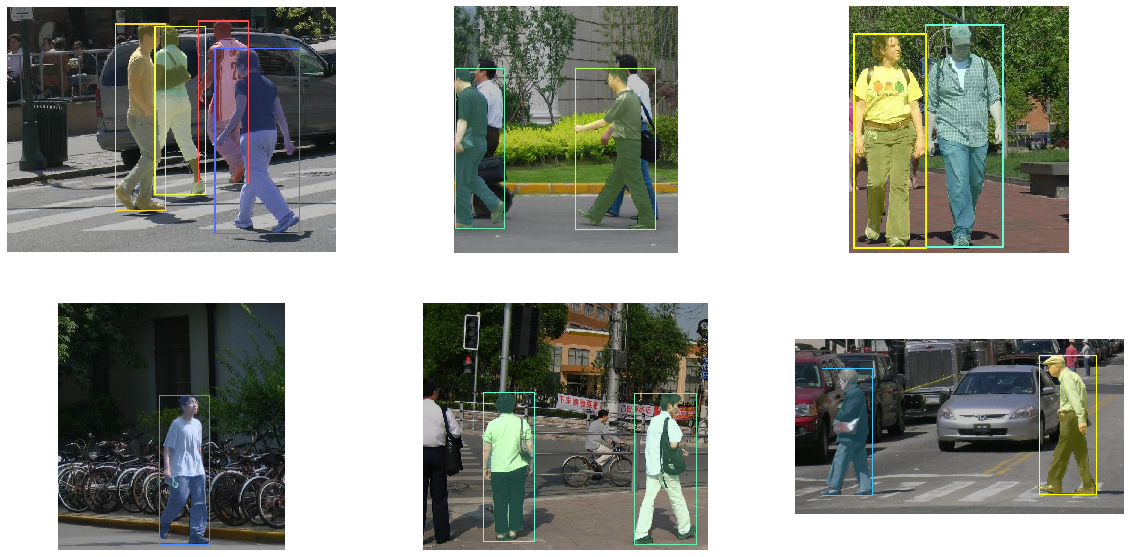

In [20]:
split = int(170*0.2)
dlist_ = np.random.permutation(dlist)

ds = [DS(i) for i in [dlist_[split:],dlist_[:split]]]
ds[0].show_sample()

---

Model stuff

In [21]:
num_classes = 2

Changing just the ROI Head (number of classes and detected bounding box per Proposal)

In [22]:
# Adjust the predictor head for number of classes
model = models.detection.maskrcnn_resnet50_fpn(True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

mid_channels = 256
in_channels = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = models.detection.mask_rcnn.MaskRCNNPredictor(in_channels, mid_channels, num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


# Transforms and Training

And now for transforms

In [23]:
def draw_boxes(img, boxes,color=(255,105,180)):
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle([*box], outline=color,width=2)
    return img

def ToTensor():
    """
    Return a function that converts the 
    input to a tensor, (div by 255).
    """
    tt = transforms.ToTensor()
    def to_tensor(img, target):
        return tt(img), target
    return to_tensor

def RandomHorizontalFlip(p=0.5):
    """
    Return function that random flips the
    image, the boxes and the masks.
    """
    def random_horizontal_flip(img, target):
        if torch.rand(1) > p:
            h, w = img.shape[1:]
            boxes = np.array(target["boxes"])
            boxes[:,[0,2]] = (w - boxes[:,[0,2]])[:,::-1]
            target["boxes"] = torch.from_numpy(boxes)
            target["masks"] = target["masks"].flip(-1)
            img = img.flip(-1)
        return img, target
        return img.to(device), {k:i.to(device) for k,i in target.items()}
    return random_horizontal_flip
        
def get_tfm(is_train=True, p=0.5):
    tf = [
        ToTensor(),
        *([RandomHorizontalFlip(p)] if is_train else []),
    ]
    def tfm(tup):
        for t in tf:
            tup = t(*tup)
        return tup
    return tfm

def to_cuda(batch):
    """
    cast a training batch to cuda
    """
    images, targets = batch
    images = [image.cuda() for image in images]
    targets = [{k:v.cuda() for k,v in target.items()} for target in targets]
    return images, targets

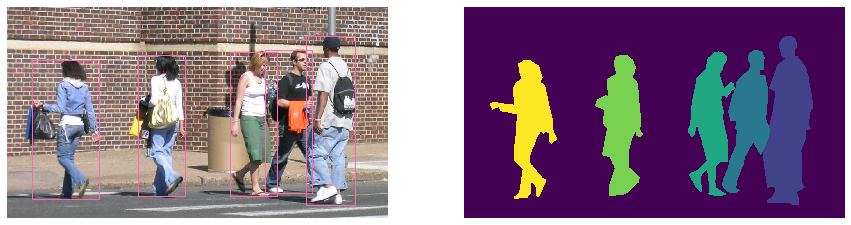

In [24]:
ds[0].transform = get_tfm(True)
ds[1].transform = get_tfm(False)

# tup = ds[0][np.random.randint(0,len(ds[0]))]
tup = ds[0][2]
plt.figure(figsize=(15,5))
imshow(draw_boxes(Image.fromarray(np.uint8(tup[0].cpu()*255).transpose(1,2,0)),tup[1]["boxes"]),1,2,1)
imshow(np.uint8(tup[1]["masks"].cpu()).argmax(axis=0)+np.uint8(tup[1]["masks"].cpu()).max(axis=0),1,2,2)

In [25]:
# For some reason the dl returns a list and not a tuple?? wtf??
# Also the zipped values should be in tuples not lists but it returns lists.
dl = [DataLoader(d,batch_size=4, shuffle=bool(i), pin_memory=True, num_workers=2,\
               collate_fn=lambda b:tuple(zip(*b))) for i,d in enumerate(ds)]
len(dl[0]),len(dl[1])

(34, 9)

Sanity Check 

In [28]:
model.train().cuda()
for batch in tqdm(dl[0]): model(*to_cuda(batch))
    
model.eval().cuda()
with torch.no_grad():
    for batch in tqdm(dl[1]): model(to_cuda(batch)[0])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Finalé

In [29]:
snreq = lambda m: [p.requires_grad_(False) for p in m.parameters()]
syreq = lambda m: [p.requires_grad_(True) for p in m.parameters()]
gpreq = lambda m: [p for p in m.parameters() if p.requires_grad]

def init(model=model, dl=dl):
    snreq(model); syreq(model.rpn); syreq(model.roi_heads)
    opt = torch.optim.SGD(gpreq(model), lr=3e-3, momentum=0.9, weight_decay=5e-4)
    sch = torch.optim.lr_scheduler.StepLR(opt, 3, gamma=0.1)
    return {"dl":dl,"model":model,"opt":opt,"sch":sch}

In [30]:
ld = {"loss_classifier": "cls", "loss_box_reg": "boxes", 
        "loss_mask": "mask", "loss_objectness": "obj", "loss_rpn_box_reg":"rpn_boxes"}
def displosses(i,losses):
    print(f"#{i:03}: L :: ",end=" ")
    [print(f"{ld[k]}:{losses[k]:0.4f}",end="  ") for k in losses]
    print()

In [31]:
def train(idict):
    model = idict["model"]; dl = idict["dl"][0]; opt = idict["opt"]
    model.train().cuda()
    accumulate = None
    for batch in tqdm(dl,leave=False):
        losses = model(*to_cuda(batch))
        loss = sum([l for l in losses.values()])
        opt.zero_grad()
        loss.backward()
        opt.step()
        if accumulate is None:
            accumulate = {loss: losses[loss].detach().item()/len(batch[0]) for loss in losses}
        else:
            for loss in losses:accumulate[loss] += losses[loss].detach().item()/len(batch[0])
    return accumulate

In [32]:
@torch.no_grad()
def eval_one(model, batch):
    return model(to_cuda(batch)[0])

@torch.no_grad()
def forward(x, model=model):
    x = x.reshape(1,*x.shape)
    return model.eval().cuda()(x.cuda())

def evaluate(idict):
    model = idict["model"]; dl = idict["dl"][1]
    model.eval().cuda()
    for batch in tqdm(dl,leave=False):
        outputs = eval_one(model, batch)
        outputs = model(to_cuda(batch)[0])

def predict_ds(ds, model=model):
    predictions = []
    targets = []
    for batch in tqdm(ds):
        image, target = batch
        targets.append(target)
        predictions.extend(forward(image, model))
    return predictions, targets

In [33]:
def fit(idict, epochs=10):
    for e in tqdm(range(epochs),leave=True):
        losses = train(idict); displosses(e, losses)
        idict["sch"].step()
#         evaluate(idict); 

In [35]:
idict = init()
fit(idict, 10)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


#000: L ::  cls:1.0682  boxes:1.8328  mask:2.8583  obj:0.1375  rpn_boxes:0.0385  


#001: L ::  cls:0.3563  boxes:0.8026  mask:1.3777  obj:0.0819  rpn_boxes:0.0389  


#002: L ::  cls:0.3293  boxes:0.5900  mask:1.3065  obj:0.0627  rpn_boxes:0.0368  


#003: L ::  cls:0.3107  boxes:0.5437  mask:1.2873  obj:0.0599  rpn_boxes:0.0371  


#004: L ::  cls:0.3188  boxes:0.5352  mask:1.2736  obj:0.0594  rpn_boxes:0.0364  


#005: L ::  cls:0.3043  boxes:0.5297  mask:1.2611  obj:0.0544  rpn_boxes:0.0334  


#006: L ::  cls:0.3058  boxes:0.5297  mask:1.2530  obj:0.0537  rpn_boxes:0.0349  


#007: L ::  cls:0.3032  boxes:0.5239  mask:1.2528  obj:0.0536  rpn_boxes:0.0356  


#008: L ::  cls:0.3095  boxes:0.5254  mask:1.2570  obj:0.0514  rpn_boxes:0.0337  


#009: L ::  cls:0.3103  boxes:0.5216  mask:1.2662  obj:0.0574  rpn_boxes:0.0334  



In [48]:
idict['opt'].param_groups[0]['initial_lr'] = 8e-4
fit(idict, 5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


#000: L ::  cls:0.3034  boxes:0.5222  mask:1.2639  obj:0.0587  rpn_boxes:0.0351  


#001: L ::  cls:0.2958  boxes:0.5170  mask:1.2596  obj:0.0495  rpn_boxes:0.0352  


#002: L ::  cls:0.3076  boxes:0.5190  mask:1.2589  obj:0.0505  rpn_boxes:0.0339  


#003: L ::  cls:0.3082  boxes:0.5255  mask:1.2663  obj:0.0612  rpn_boxes:0.0332  


#004: L ::  cls:0.3057  boxes:0.5217  mask:1.2612  obj:0.0547  rpn_boxes:0.0335  



# Evaluation

In [38]:
comp_mask = lambda seg:(seg * np.arange(1,seg.shape[0]+1,dtype=np.uint8).reshape(-1,1,1)).max(axis=0)
# font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf",15)

# This will have to be uploaded.
font = ImageFont.truetype("inconsolata.ttf",15)
def draw_boxes_color(img, color, boxes,iou=None,scores=None):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    for i,(c,bb) in enumerate(zip(color,boxes)):
        draw.rectangle([*bb], outline=c, width=2)
        if scores is not None:
            draw.text([*(bb[:2]+5)],f"{scores[i]:0.4f}", (int(255*(1-scores[i])),255,0), font=font)
        if iou is not None:
            draw.text([*(bb[2:]-[60,20])],f"{iou[i]:0.4f}", (int(255*(1-iou[i])),255,0), font=font)
    return np.array(img)

def evaluate_one(idx,ds=ds[1],model=model):
    img_act = ds.show(idx)
    x,tgt = ds[idx]

    # Thresholds
    th = 0.7
    m_th = 0.5

    # Inference
    op = forward(x)[0]

    # Mask and BBoxes
    mask = op["scores"] > th
    scores = op["scores"][mask].cpu()
    boxes = np.int64(op["boxes"][mask].cpu())

    # Seg map and conf maps and box iou
    seg = op["masks"][mask].cpu()
    seg = seg.reshape(-1,*seg.shape[-2:])
    conf_map = seg.max(dim=0)[0]
    seg = np.uint8(seg > m_th)
    seg = comp_mask(seg)
    seg,cols = get_mask(seg)
    iou = ops.box_iou(torch.from_numpy(boxes).float(),tgt["boxes"]).max(dim=1)[0]

    # Writing infor to the image
    img = np.uint8((x * 255).cpu()).transpose(1,2,0)
    img = np.array(draw_boxes(Image.fromarray(img), tgt["boxes"],(0,255,0)))
    img = get_masked(img,seg,0.4)
    img = draw_boxes_color(img, cols, boxes, iou, scores)

    plt.figure(figsize=(20,5))
    imshow(conf_map, 1, 3, 1,title="conf map")
    imshow(seg, 1, 3, 2,title="pred inst seg")
    imshow(comp_mask(tgt["masks"].numpy()), 1, 3, 3, title="ground truth")

    plt.figure(figsize=(20,8))
    imshow(img, 1, 2, 1,title="pred img")
    imshow(img_act, 1, 2, 2,title="ground truth")

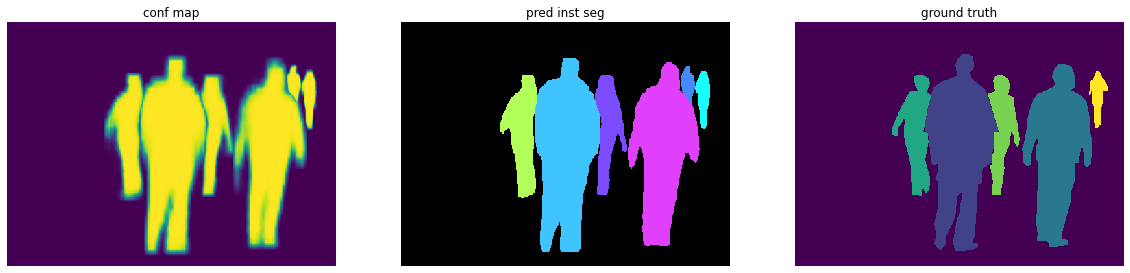

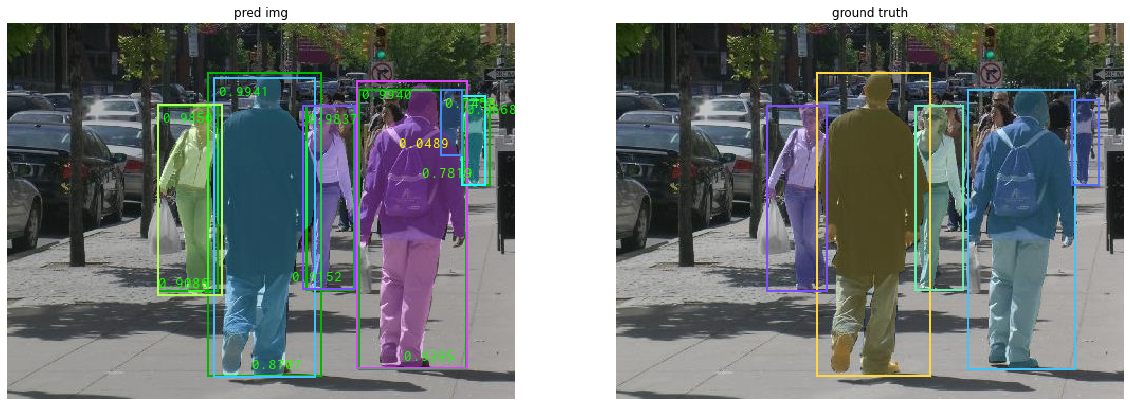

In [60]:
evaluate_one(18)

# Metrics

[Reference](https://blog.zenggyu.com/en/post/2018-12-16/an-introduction-to-evaluation-metrics-for-object-detection/)
## Base Scores
- **Confidence score**: probability that the bounding box has an object. output is thresholded by confidence scores, i.e. if `score > thresh_conf` then there is an object. (*standalone metric*)
- **IoU**: Intersection over Union with respect to ground truth bounding box of the same class. IoU is also thresholded. (not standalone, requires ground truth, is an *evaluation metric*)

## From Base Scores
- **True Positive** : if `score > thresh_conf` and `iou > thresh_iou` and `pred_class == true_class`
- **False Positive** : if `score > thresh_conf` and `iou < thresh_iou` or `pred_class != true_class`
- **True Negative** : if `score < thresh_conf` and `iou < thresh_iou` or `pred_class != true_class`
- **False Negative** : if `score < thresh_conf` and `iou > thresh_iou` and (or?) `pred_class == true_class`
- Positive is when the model is confident that there is an obeject in the bounding box.
- Negative is when the counter is true which is the interpretation of a score below the threshold.
- True (positive) is when the IoU is high enough and the classes match the ground truth object.
- False (positive) is when the IoU is low or the classes don't match the ground truth object.
- For negatives the counter is true.

## Further calculated
- **Precision** = `TP / (TP + FP)`, penalizes for false positives. Is my country under attack?
- **Recall** = `TP / (TP + FN)`, penalizes for false negatives. Does this person have a tumour?
- From precision and recall computations the `precision-recall` curve can be plotted by applying different confidence metrics.


Assume classes match (only one class in this case).
```python
tp = conf > th and iou > th
fp = conf > th and iou < th
fn = conf < th and iou > th
tn = conf < th and iou < th
```

In [61]:
preds,targets = predict_ds(ds[1])
preds = [{k:p[k].cpu()for k in p}for p in preds]
len(preds), len(targets)

(34, 34)

In [68]:
def seg_iou(pmask,tmask, th=0.5):
    """
    pmask : predicted mask
    tmask : target mask
    th : predicted mask threshold
    """
    pmask = pmask.reshape(-1, *pmask.shape[2:])
    pmask = (pmask > th).type(torch.uint8)
    pareas = pmask.sum(dim=(1,2))
    tareas = tmask.sum(dim=(1,2))
    inter = ((pmask.unsqueeze(1) + tmask.unsqueeze(0)) == 2)
    inter = inter.sum(dim=(2,3))
    union = (pareas.unsqueeze(1) + tareas.unsqueeze(0) - inter).float()
    return inter/union

In [69]:
def get_metrics(preds, targets, mask_th=0.5):
    seg_ious = [seg_iou(p["masks"],t["masks"]).max(dim=1)[0] for p,t in zip(preds, targets)]
    box_ious = [ops.box_iou(p["boxes"],t["boxes"]).max(dim=1)[0] for p,t in zip(preds, targets)]
    areas = [t["area"] for t in targets]
    confs = [p["scores"] for p in preds]
    return {
        "seg_iou":seg_ious,
        "box_iou":box_ious,
        "areas":areas,
        "confs":confs
    }
def cat_metrics(metrics): return {k:torch.cat(metrics[k])for k in metrics}

In [70]:
metrics = get_metrics(preds, targets)
cmetrics = cat_metrics(metrics)
[(k,len(cmetrics[k])) for k in cmetrics]

[('seg_iou', 271), ('box_iou', 271), ('areas', 91), ('confs', 271)]

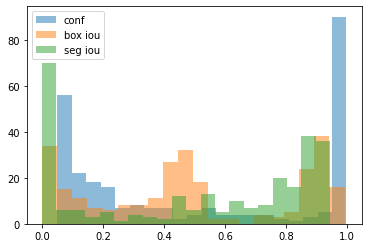

In [71]:
cnf = cmetrics["confs"].numpy() # Confidence scores
biou = cmetrics["box_iou"].numpy() # Box IoU scores
siou = cmetrics["seg_iou"].numpy() # Seg IoU scores

plt.hist(cnf,20,alpha=0.5,label="conf")
plt.hist(biou,20,alpha=0.5,label="box iou")
plt.hist(siou,20,alpha=0.5,label="seg iou")
plt.legend();

In [72]:
cnf_th = 0.8
mask = cnf > cnf_th

print(f"+ det conf > {cnf_th} :: {mask.sum()}")
confident_boxes = biou[mask]
confident_segms = siou[mask]

det_th = 0.7
gt_bcnf = confident_boxes > det_th
gt_scnf = confident_segms > det_th

print(f"+ det count iou > {det_th}:: box {gt_bcnf.sum():5}, seg {gt_scnf.sum():5}")
print(f"+ det mean  iou > {det_th}:: box {gt_bcnf.mean():0.3f}, seg {gt_scnf.mean():0.3f}")

+ det conf > 0.8 :: 100
+ det count iou > 0.7:: box    88, seg    88
+ det mean  iou > 0.7:: box 0.880, seg 0.880


In [89]:
def get_prec_recl(cnf,iou, iou_th=None):
    idx = cnf.argsort()[::-1]
    cnf = cnf[idx]
    iou = iou[idx]
    if iou_th is not None:
        tru = iou >= iou_th
        fls = iou < iou_th
    
    ths = []; tps = []; fps = []; tns = []; fns = []
    for th in np.arange(0.95,0.45,-0.05):
        pos = cnf >= th; neg = cnf < th
        if iou_th is None:
            tru = iou >= th; fls = iou < th
            
        ths.append(th)
        tps.append((pos & tru).sum())
        fps.append((pos & fls).sum())
        tns.append((neg & fls).sum())
        fns.append((neg & tru).sum())
        
    ths,tps,fps,tns,fns = [np.array(m) for m in (ths,tps,fps,tns,fns)]
    return {
        "prec":tps/(tps+fps+1e-8), "recl":tps/(tps+fns+1e-8),
        "ths": ths, "tps":tps, "fps":fps, "tns":tns,"fns":fns,
        "cnf":cnf,"iou":iou
    }

def plot(x,y,xlabel="",ylabel="",xlim=None,ylim=None,grid=True,func=plt.plot):
    func(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    xlim is not None and plt.xlim(*xlim)
    ylim is not None and plt.ylim(*ylim)
    grid and plt.grid()
    
def metric_printer(m):
    h = "|  # |   th |   prec |   recl |  tp |  fp |  tn |  fn |"
    print(f"{h}\n{len(h)*'-'}")
    [print(f'| {i+1:2} | {th:0.2f} | {m["prec"][i]:0.4f} | {m["recl"][i]:0.4f} |'+\
          f' {m["tps"][i]:3} | {m["fps"][i]:3} | {m["tns"][i]:3} | {m["fns"][i]:3} |')\
     for i,th in enumerate(m["ths"])];

## Metrics when sweeping the IoU threshold

In [90]:
bm = get_prec_recl(cnf, biou)
print("Box IoUs"); metric_printer(bm); print()

sm = get_prec_recl(cnf, siou)
print("Segmentation IoUs"); metric_printer(sm);

Box IoUs
|  # |   th |   prec |   recl |  tp |  fp |  tn |  fn |
-------------------------------------------------------
|  1 | 0.95 | 0.1236 | 1.0000 |  11 |  78 | 182 |   0 |
|  2 | 0.90 | 0.5158 | 0.9800 |  49 |  46 | 175 |   1 |
|  3 | 0.85 | 0.7653 | 1.0000 |  75 |  23 | 173 |   0 |
|  4 | 0.80 | 0.8200 | 1.0000 |  82 |  18 | 171 |   0 |
|  5 | 0.75 | 0.8431 | 1.0000 |  86 |  16 | 169 |   0 |
|  6 | 0.70 | 0.8302 | 0.9888 |  88 |  18 | 164 |   1 |
|  7 | 0.65 | 0.8036 | 1.0000 |  90 |  22 | 159 |   0 |
|  8 | 0.60 | 0.7982 | 0.9891 |  91 |  23 | 156 |   1 |
|  9 | 0.55 | 0.7583 | 0.9681 |  91 |  29 | 148 |   3 |
| 10 | 0.50 | 0.7323 | 0.8455 |  93 |  34 | 127 |  17 |

Segmentation IoUs
|  # |   th |   prec |   recl |  tp |  fp |  tn |  fn |
-------------------------------------------------------
|  1 | 0.95 | 0.0000 | 0.0000 |   0 |  89 | 182 |   0 |
|  2 | 0.90 | 0.3579 | 0.9714 |  34 |  61 | 175 |   1 |
|  3 | 0.85 | 0.6633 | 0.8784 |  65 |  33 | 164 |   9 |
|  4 | 0.80 | 0.7500

## Metrics when keeping the IoU threshold constant

In [91]:
bm = get_prec_recl(cnf, biou,iou_th=0.75)
print("Box IoUs - Fixed"); metric_printer(bm); print()

sm = get_prec_recl(cnf, siou,iou_th=0.75)
print("Segmentation IoUs - Fixed"); metric_printer(sm);

Box IoUs - Fixed
|  # |   th |   prec |   recl |  tp |  fp |  tn |  fn |
-------------------------------------------------------
|  1 | 0.95 | 0.9101 | 0.9419 |  81 |   8 | 177 |   5 |
|  2 | 0.90 | 0.8947 | 0.9884 |  85 |  10 | 175 |   1 |
|  3 | 0.85 | 0.8776 | 1.0000 |  86 |  12 | 173 |   0 |
|  4 | 0.80 | 0.8600 | 1.0000 |  86 |  14 | 171 |   0 |
|  5 | 0.75 | 0.8431 | 1.0000 |  86 |  16 | 169 |   0 |
|  6 | 0.70 | 0.8113 | 1.0000 |  86 |  20 | 165 |   0 |
|  7 | 0.65 | 0.7679 | 1.0000 |  86 |  26 | 159 |   0 |
|  8 | 0.60 | 0.7544 | 1.0000 |  86 |  28 | 157 |   0 |
|  9 | 0.55 | 0.7167 | 1.0000 |  86 |  34 | 151 |   0 |
| 10 | 0.50 | 0.6772 | 1.0000 |  86 |  41 | 144 |   0 |

Segmentation IoUs - Fixed
|  # |   th |   prec |   recl |  tp |  fp |  tn |  fn |
-------------------------------------------------------
|  1 | 0.95 | 0.9101 | 0.7168 |  81 |   8 | 150 |  32 |
|  2 | 0.90 | 0.8947 | 0.7522 |  85 |  10 | 148 |  28 |
|  3 | 0.85 | 0.8776 | 0.7611 |  86 |  12 | 146 |  27 |
|  4

## Average Precision
- Average precsion is taken to be the area under the Precision-Recall curve. (i.e. the integral of the curve)
- This is calculated by first interpolating the precision points which don't monotonically decrease like recall.
- So At any recall value the precision assigned is the max of all the precisions for all subsequent recall values.
- This makes the curve rectangular, making the area calculation easier. Sum of area of the rectangles (integral approximation width tends to 0).

## mean Average Precision
- This is the average precision that has been averaged over all of the classes.
- mAP for COCO dataset is the classwise mean AP averaged over a range of IoU thresholds mostly [0.95:0.05:0.5]

In [112]:
def interp_prec(prec):
    """
    Interpolate Precision
    """
    mx = -1; interp = []
    for p in prec[::-1]:
        if p > mx:
            interp.append(p)
            mx = p
        else:
            interp.append(interp[-1])
    return interp[::-1]

def ap(m):
    """
    Calculated under the assumption that when lim threshold => 1
    precision => 1 and recall => 0, calculation under this assumption
    may be very wrong.
    """
    p = [1,*interp_prec(m["prec"])]
    r = [0,*m["recl"]]
    return sum([(r[i+1]-r[i])*p[i] for i in range(len(r)-1)])

def get_ap(cnf, siou, biou, th=0.75):
    bm = get_prec_recl(cnf, biou, iou_th=th)
    sm = get_prec_recl(cnf, siou, iou_th=th)
    return ap(bm),ap(sm)

def get_map(cnf,siou,biou,to_print=True):
    aps = []
    for i in np.arange(0.95,0.45,-0.05):
        bap,sap = get_ap(cnf, siou, biou, i)
        to_print and print(f"AP @ {i:0.2f} :: box : {bap:0.4f}, seg : {sap:0.4f}")
        aps.append((bap,sap))
    return np.array(aps).mean(axis=0)

In [113]:
# These values seem ~kinda~ very bs.
get_map(cnf,siou,biou)

AP @ 0.95 :: box : 1.0000, seg : 0.0000
AP @ 0.90 :: box : 0.9811, seg : 0.9714
AP @ 0.85 :: box : 0.9920, seg : 0.8746
AP @ 0.80 :: box : 0.9937, seg : 0.8257
AP @ 0.75 :: box : 0.9946, seg : 0.7710
AP @ 0.70 :: box : 0.9941, seg : 0.7502
AP @ 0.65 :: box : 0.9949, seg : 0.7262
AP @ 0.60 :: box : 0.9848, seg : 0.6683
AP @ 0.55 :: box : 0.9639, seg : 0.6519
AP @ 0.50 :: box : 0.8380, seg : 0.6068


array([0.97371481, 0.68460353])

## Pascal VOC AP
- True Positive whent the IoU is greater than 0.5 else false positive.

In [114]:
def pascal_voc_ap(iou):
    """
    Reference : http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html
    """
    tp = (iou > 0.5).sum()
    fp = len(iou) - tp 

    return tp/(tp+fp)

Unthresholded PascalVOC average precision

In [115]:
pascal_voc_ap(biou),pascal_voc_ap(siou)

(0.4059040590405904, 0.5756457564575646)

Confidence thresholded PascalVOC average precision

In [116]:
th = 0.5
pascal_voc_ap(biou[cnf>th]),pascal_voc_ap(siou[cnf>th])

(0.7322834645669292, 0.7559055118110236)

## Curves
### Precision - Recall curve
- Every point in the curve is obtained by varying the threshold for counting a sample as positive.
- The threshold is swept from 0.95 to 0.5 in steps of 0.05
- Recall monotonically increases as the number of total negatives decreases.
- Precision decreases non monotonically.

### Recall - IoU (Threshold) curve
- Change in recall plotted with increasing IoU threshold.
- As the IoU thresh increases the number of samples being termed as False Negatives will decrease right?

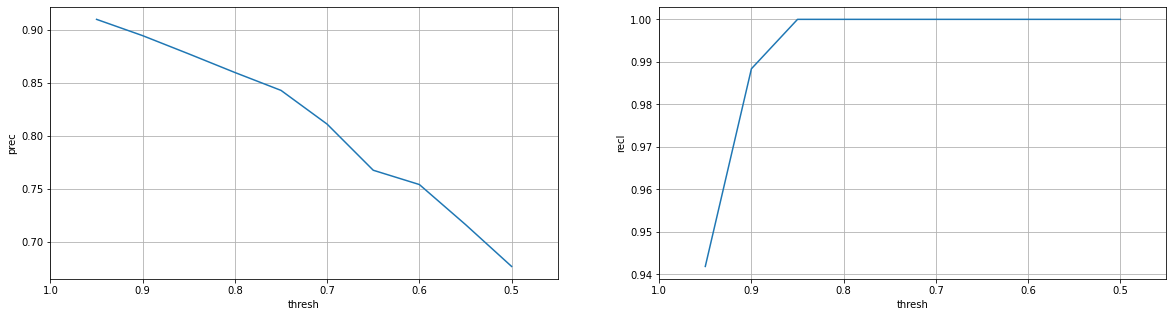

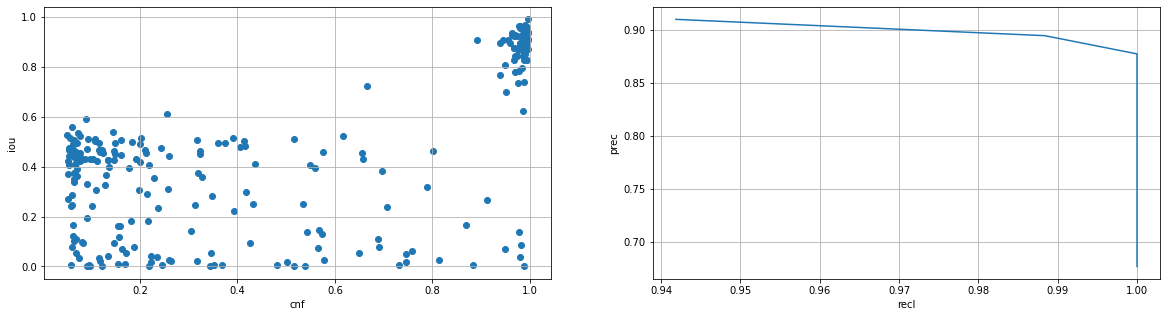

In [117]:
"""
Metrics using Box IoUs
"""

plt.figure(figsize=(20,5))
plt.subplot(1,2,1); plot(bm["ths"],bm["prec"],xlabel="thresh",ylabel="prec",xlim=(1,0.45))
plt.subplot(1,2,2); plot(bm["ths"],bm["recl"],xlabel="thresh",ylabel="recl",xlim=(1,0.45))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1); plot(bm["cnf"],bm["iou"],xlabel="cnf",ylabel="iou",func=plt.scatter)
plt.subplot(1,2,2); plot(bm["recl"],bm["prec"],xlabel="recl",ylabel="prec")

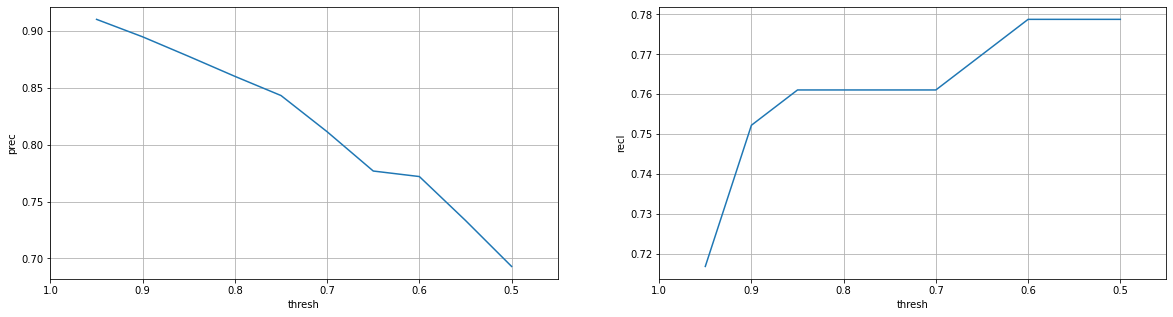

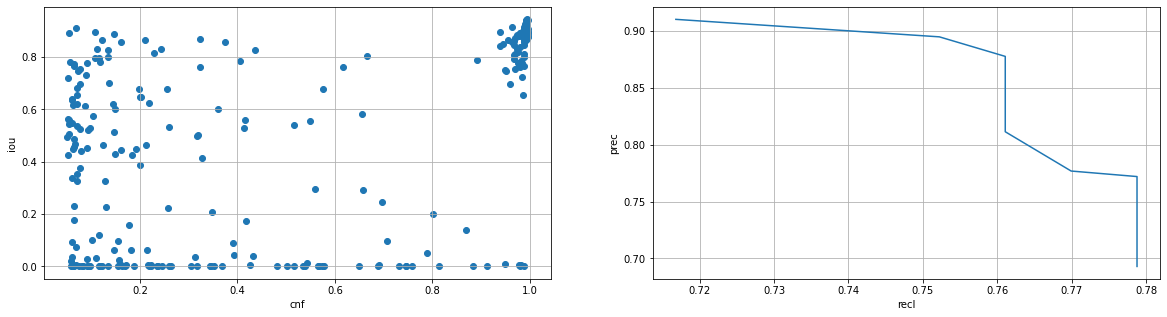

In [118]:
"""
Metrics using Segmentation IoUs
"""

plt.figure(figsize=(20,5))
plt.subplot(1,2,1); plot(sm["ths"],sm["prec"],xlabel="thresh",ylabel="prec",xlim=(1,0.45))
plt.subplot(1,2,2); plot(sm["ths"],sm["recl"],xlabel="thresh",ylabel="recl",xlim=(1,0.45))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1); plot(sm["cnf"],sm["iou"],xlabel="cnf",ylabel="iou",func=plt.scatter)
plt.subplot(1,2,2); plot(sm["recl"],sm["prec"],xlabel="recl",ylabel="prec")